In [1]:
!nvidia-smi

Sun Jul 10 07:35:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mounting GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initialise LRCN

In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import h5py
import numpy as np
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader

In [5]:
# GITHUB PROJECT FOLDER
import sys

project_path = '/content/drive/MyDrive/diss/3D-GAN'
src_path = f'{project_path}/3D-GAN'
sys.path.append(src_path) # adding path to sys
from src.LRCN import LRCN, weights_init

In [6]:
data_path = f'{project_path}/data'

In [7]:
# # importing from h5 file
# f = h5py.File(f'{data_path}/{data_filename}.h5', 'r')
# dataset = torch.from_numpy(np.array(f[list(f.keys())[0]]).reshape(-1, 1, input_dim, input_dim, input_dim)).to(torch.float)
# print('dataset shape:', dataset.shape)

In [8]:
### HYPERPARAMETERS ###
# LRCN
input_dim = 64
output_dim = 128
c = 5

# OPTIMIZER
lr = 1e-4
beta1 = 0.5
beta2 = 0.999

batch_size = 50 # update net with every batch size
mini_batch_size = 10 # size that actually goes to GPU
workers = 0
run_parallel = False

k = int(batch_size / mini_batch_size)
print('batch size:', batch_size, 'mini batch:', mini_batch_size, 'k:', k)

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch size: 50 mini batch: 10 k: 5
Random Seed:  42


# Importing data

In [9]:
# importing from binvox files
from src import binvox_rw

num_models = 500
# input models of resolution 64
data_filename = f'shapenet-lamp-binvox-{input_dim}'
binvox_files = os.listdir(os.path.join(data_path, data_filename))[:num_models]
print('number of binvox files:', len(binvox_files))
lst_binvox_input = []
for file in tqdm(binvox_files):
  with open(os.path.join(data_path, data_filename, file), 'rb') as f:
    m = binvox_rw.read_as_3d_array(f).data
    lst_binvox_input.append(m)

data_filename = f'shapenet-lamp-binvox-{output_dim}'
binvox_files = os.listdir(os.path.join(data_path, data_filename))[:num_models]
lst_binvox_target = []
for file in tqdm(binvox_files):
  with open(os.path.join(data_path, data_filename, file), 'rb') as f:
    m = binvox_rw.read_as_3d_array(f).data
    lst_binvox_target.append(m)

number of binvox files: 500


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
arr_input = np.array(lst_binvox_input)
arr_target = np.array(lst_binvox_target)
arr_input = arr_input.reshape(-1, 1, input_dim, input_dim, input_dim)
arr_target = arr_target.reshape(-1, 1, output_dim, output_dim, output_dim)
input_tensors = torch.from_numpy(arr_input).to(torch.float)
target_tensors = torch.from_numpy(arr_target).to(torch.float)
print(input_tensors.shape)
print(target_tensors.shape)

torch.Size([500, 1, 64, 64, 64])
torch.Size([500, 1, 128, 128, 128])


In [11]:
num_train = int(num_models * 0.8)

train_input_dataloader = DataLoader(
    input_tensors[:num_train], 
    batch_size=batch_size,
    # shuffle=True, 
    shuffle=False,
    num_workers=workers,
)

val_input_dataloader = DataLoader(
    input_tensors[num_train:], 
    batch_size=int(batch_size * 0.2),
    # shuffle=True, 
    shuffle=False,
    num_workers=workers,
)

train_target_dataloader = DataLoader(
    target_tensors[:num_train], 
    batch_size=batch_size,
    # shuffle=True, 
    shuffle=False,
    num_workers=workers,
)

val_target_dataloader = DataLoader(
    target_tensors[num_train:], 
    batch_size=int(batch_size * 0.2),
    # shuffle=True, 
    shuffle=False,
    num_workers=workers,
)

print('number of train batches:', len(train_input_dataloader))
print('number of validation batches:', len(val_input_dataloader))

number of train batches: 8
number of validation batches: 10


# Initialise LRCN

In [12]:
input_shape = (1, 1, input_dim, input_dim, input_dim)
print('input shape:', input_shape)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

net = LRCN(input_dim=input_dim, kernel_size=3,
           output_dim=output_dim, hidden_size=1000)
net = net.to(device)
opt = optim.Adam(net.parameters(), lr=lr, betas=(beta1, beta2))
# criterion = torch.nn.BCELoss()
criterion = torch.nn.L1Loss()
net.apply(weights_init)
print("\n\nNetwork summary\n\n")
summary(net, input_shape)

input shape: (1, 1, 64, 64, 64)
device: cuda


Network summary




Layer (type:depth-idx)                   Output Shape              Param #
LRCN                                     [1, 1, 128, 128, 128]     --
├─Sequential: 1-1                        [1, 64, 32, 32, 3]        --
│    └─Conv3d: 2-1                       [1, 64, 32, 32, 3]        1,728
│    └─BatchNorm3d: 2-2                  [1, 64, 32, 32, 3]        128
│    └─LeakyReLU: 2-3                    [1, 64, 32, 32, 3]        --
├─Sequential: 1-2                        [1, 128, 16, 16, 2]       --
│    └─Conv3d: 2-4                       [1, 128, 16, 16, 2]       221,184
│    └─BatchNorm3d: 2-5                  [1, 128, 16, 16, 2]       256
│    └─LeakyReLU: 2-6                    [1, 128, 16, 16, 2]       --
├─Sequential: 1-3                        [1, 256, 8, 8, 1]         --
│    └─Conv3d: 2-7                       [1, 256, 8, 8, 1]         884,736
│    └─BatchNorm3d: 2-8                  [1, 256, 8, 8, 1]         512
│    └─LeakyReLU: 2-9                    [1, 256, 8, 8, 1]         --

In [13]:
weights_path = f'{project_path}/weights/LRCN'
os.makedirs(weights_path, exist_ok=True)

In [ ]:
num_epochs = 100

# Training Loop
print("Starting Training Loop...")
lst_loss = []
lst_val_loss = []
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, input_data_all in enumerate(train_input_dataloader, 0): # batch
        lst_batch_loss = []
        target_data_all = next(iter(train_target_dataloader))
        val_input_data = next(iter(val_input_dataloader)).to(device)
        val_target_data = next(iter(val_target_dataloader)).to(device)
        
        # mini batch
        input_data_split = torch.split(input_data_all, mini_batch_size)
        target_data_split = torch.split(target_data_all, mini_batch_size)

        opt.zero_grad()

        for j in range(len(input_data_split)):
            input_data = input_data_split[j].to(device)
            target_data = target_data_split[j].to(device)
            output_data = net(input_data)
            # Calculate loss
            err = criterion(output_data, target_data) / len(input_data_split)
            lst_batch_loss.append(err.item())
            err.backward() # err grad to opt
            if j==len(input_data_split)-1: # if the end of mini-batch iteration (one batch done)
                opt.step()  # update the weights only after accumulating k mini batches
                opt.zero_grad()  # reset gradients for accumulation for the next large batch
        lst_loss.append(np.sum(lst_batch_loss)) # average of losses in one batch
        
        # validation
        with torch.no_grad():
          val_output_data = net(val_input_data)
        val_err = criterion(val_output_data, val_target_data)
        lst_val_loss.append(val_err)
            
        # Output training stats
        if i % 5 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_input_dataloader)}]\tLoss: {round(err.item(), 4)}\tVal loss: {round(val_err.item(), 4)}')
            
        # iters += 1
    
    if epoch % 5 == 0 and epoch != 0:
      # plot_convergence(G_losses, D_real_losses, D_fake_losses, real_accuracies, fake_accuracies)
      # save network weights
      net_filename = os.path.join(weights_path, f'net_r{input_dim}_r{output_dim}_e{epoch}_weights.pth')
      torch.save(net.state_dict(), net_filename)
      print('saved network weights', net_filename)


# torch.save(net.state_dict(), f'{weights_path}/net_e{epoch}_r{input_dim}_r_{output_dim}_weights.pth')

Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/8]	Loss: 0.0495	Val loss: 0.2257
[0/100][5/8]	Loss: 0.0219	Val loss: 0.0913
[1/100][0/8]	Loss: 0.0144	Val loss: 0.0618
[1/100][5/8]	Loss: 0.0101	Val loss: 0.0475
[2/100][0/8]	Loss: 0.0088	Val loss: 0.0403
[2/100][5/8]	Loss: 0.0078	Val loss: 0.0379
[3/100][0/8]	Loss: 0.0075	Val loss: 0.0344
[3/100][5/8]	Loss: 0.0071	Val loss: 0.0341
[4/100][0/8]	Loss: 0.0069	Val loss: 0.0317
[4/100][5/8]	Loss: 0.0067	Val loss: 0.0318
[5/100][0/8]	Loss: 0.0065	Val loss: 0.0299
[5/100][5/8]	Loss: 0.0063	Val loss: 0.0302
saved network weights /content/drive/MyDrive/diss/3D-GAN/weights/LRCN/net_r64_r128_e5_weights.pth
[6/100][0/8]	Loss: 0.0063	Val loss: 0.0286
[6/100][5/8]	Loss: 0.0061	Val loss: 0.0293
[7/100][0/8]	Loss: 0.0061	Val loss: 0.0278
[7/100][5/8]	Loss: 0.0059	Val loss: 0.0282
[8/100][0/8]	Loss: 0.0059	Val loss: 0.0271
[8/100][5/8]	Loss: 0.0058	Val loss: 0.0274
[9/100][0/8]	Loss: 0.0058	Val loss: 0.0266
[9/100][5/8]	Loss: 0.0057	Val loss: 0.0267
[10/100][0/8]	Loss: 0.0056	Val loss: 0.026

In [ ]:
# weights_path = f'{project_path}/weights/LRCN'
# os.makedirs(weights_path, exist_ok=True)
# file_net = f'{weights_path}/net_r{input_dim}_r{output_dim}_e{epoch}_weights.pth'
# torch.save(net.state_dict(), file_net)

In [14]:
file_net = os.path.join(weights_path, 'net_r64_r128_e35_weights.pth')
net.load_state_dict(torch.load(file_net))

<All keys matched successfully>

In [15]:
input_data = next(iter(train_input_dataloader))[:10]
print(input_data.shape)

torch.Size([10, 1, 64, 64, 64])


In [16]:
input_data = input_data.to(device)
output_data = net(input_data)
print(output_data.shape)

torch.Size([10, 1, 128, 128, 128])


input 0


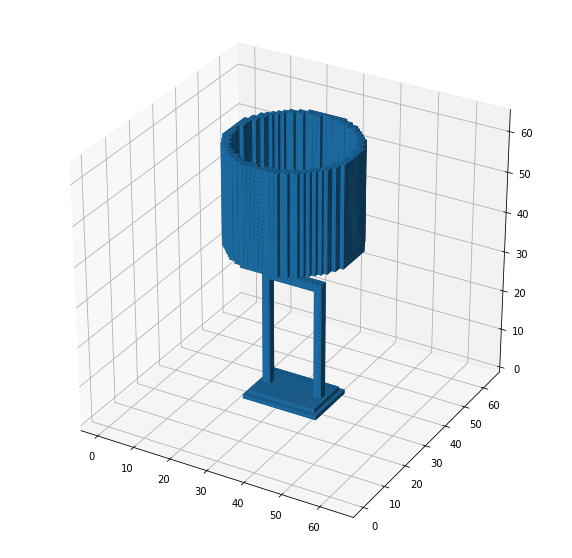

output 0


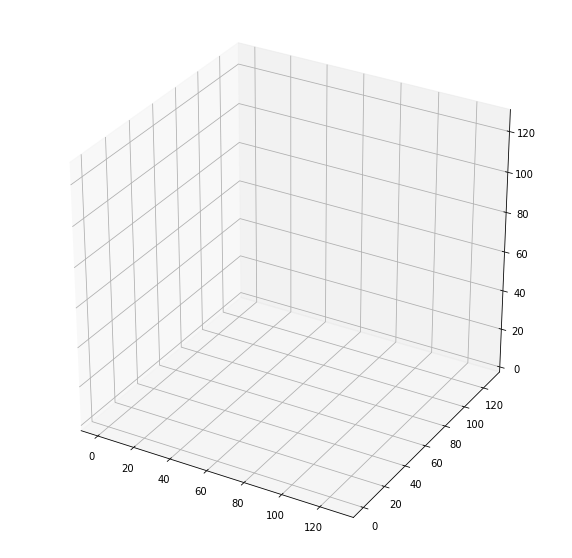

input 1


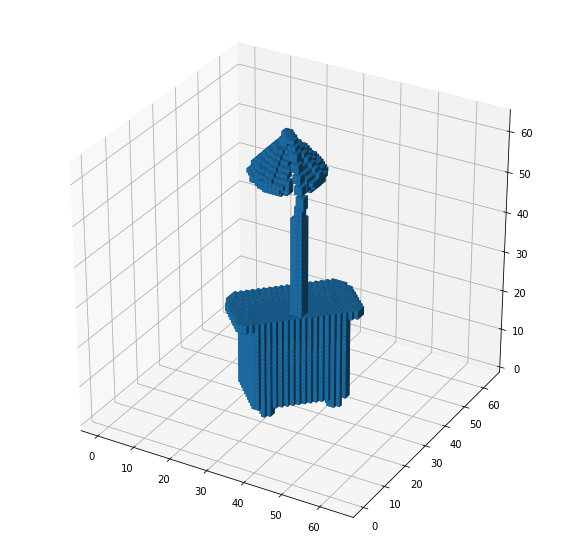

output 1


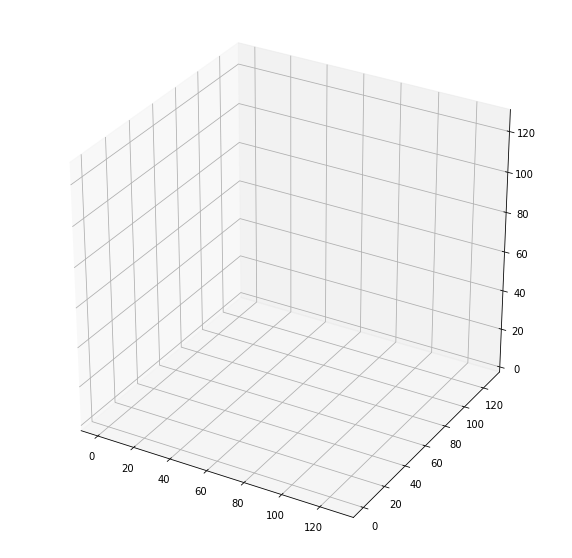

input 2


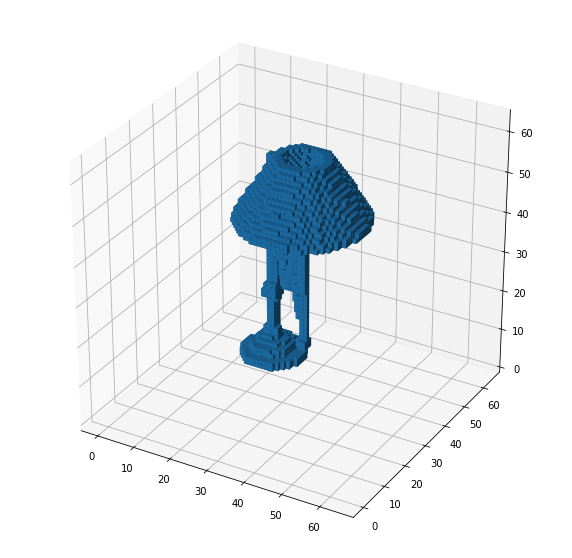

output 2


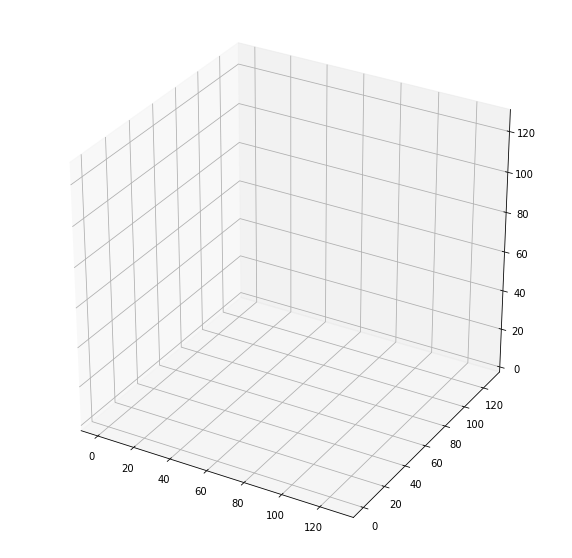

input 3


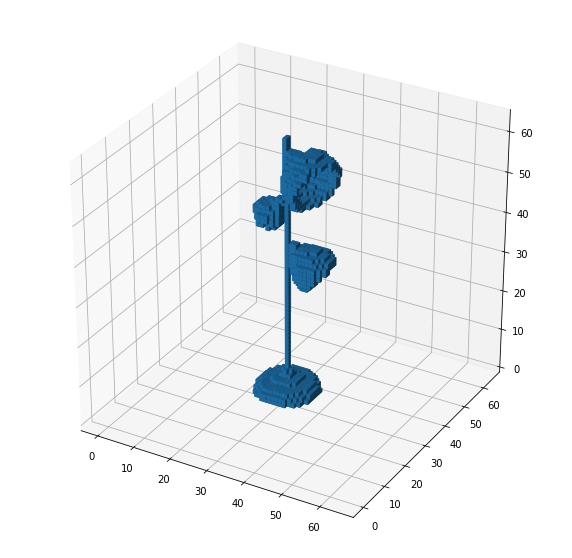

output 3


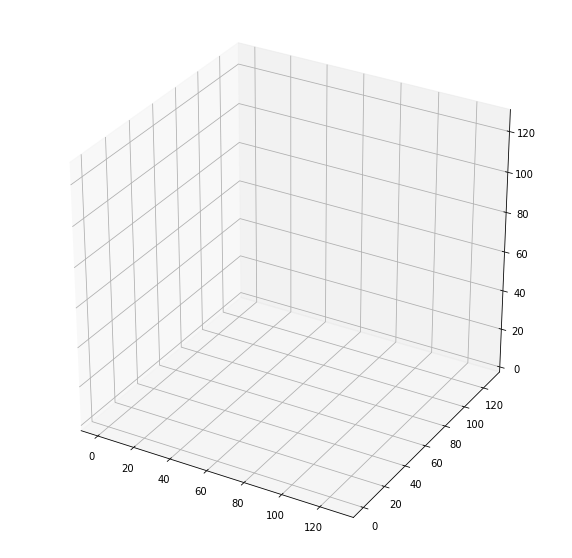

input 4


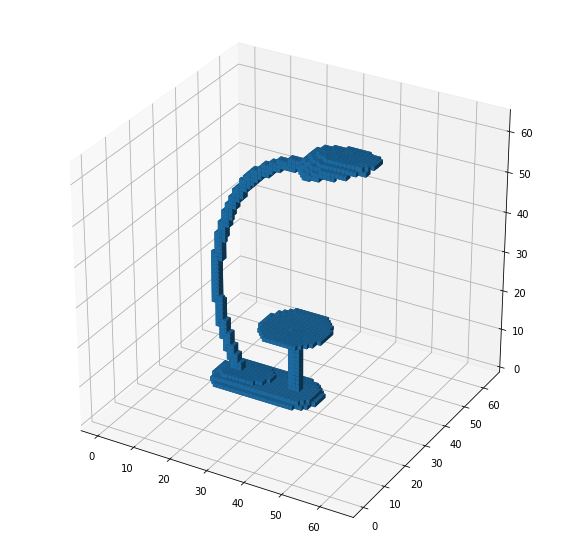

output 4


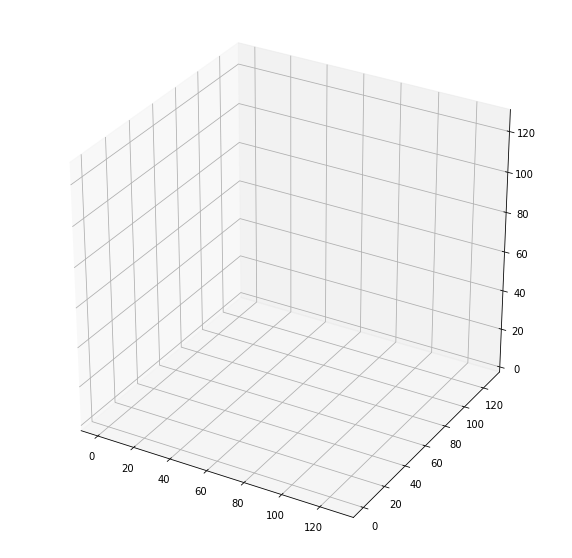

input 5


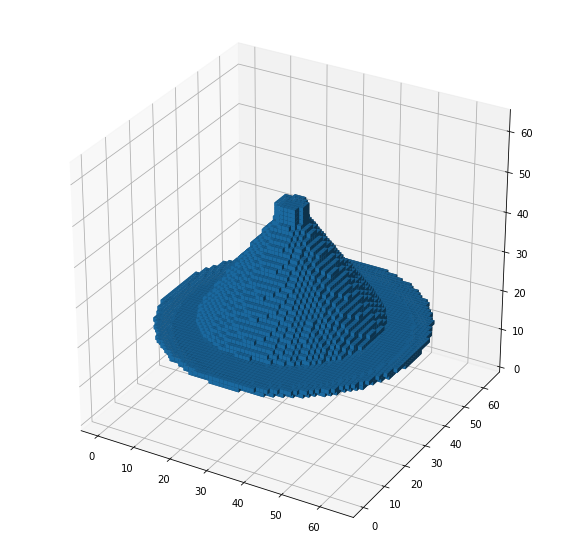

output 5


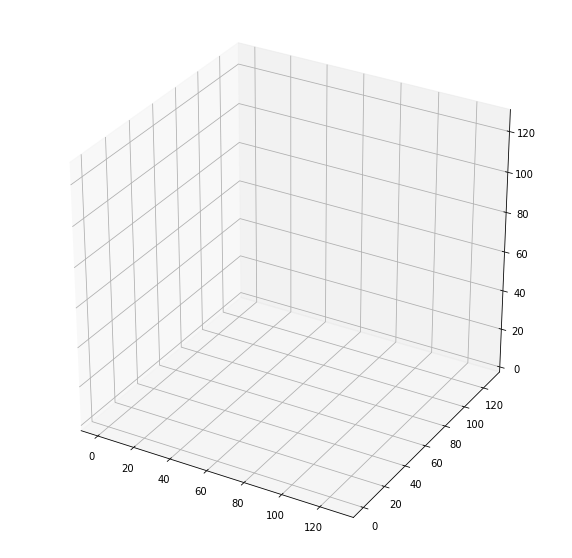

input 6


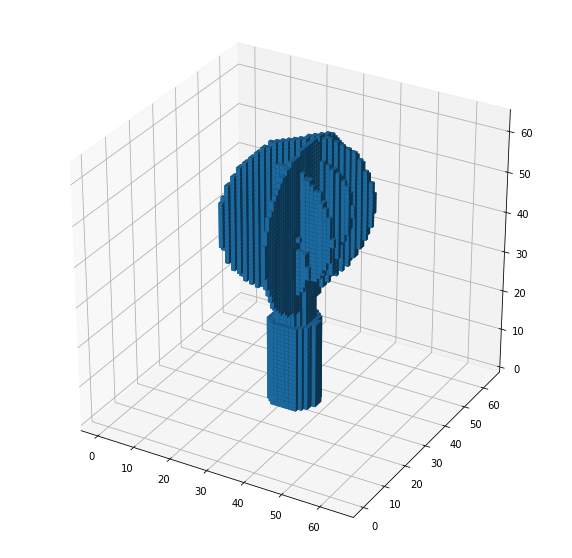

output 6


KeyboardInterrupt: ignored

In [17]:
for i in range(10):
    input_sample = input_data[i][0].cpu().numpy()
    output_sample = output_data[i][0].detach().cpu().numpy()
    output_sample = (output_sample > 0.5).astype(int)

    print('input', i)
    # ax = plt.figure().add_subplot(projection='3d')
    ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
    ax.voxels(input_sample)
    plt.show()

    print('output', i)
    # ax = plt.figure().add_subplot(projection='3d')
    ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
    ax.voxels(output_sample)
    plt.show()

In [ ]:

output_sample = output_data[i][0].detach().cpu().numpy()
output_sample = (output_sample > 0.1).astype(int)
print((output_sample==0).all())